In [1]:
# !pip3 install pandas
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
import os
import json

plt.style.use('dark_background')

Parse all results and load it to DataFrame.

In [32]:
def parse_results(resultsdir, repr, lr, wd, printing=False):
    outpath = '{}_' + 'lr_{:.3f}_wd_{:.3f}'.format(lr, wd) + '_expid_{:d}_lowshotn_{:d}.json' 
    lowshotns = [1,2,5, 10]
    expids = [1,2,3,4,5]
    all_nums = np.zeros((len(lowshotns), len(expids), 4))
    for i, ei in enumerate(expids):
        for j, ln in enumerate(lowshotns):
            outfile = os.path.join(resultsdir, outpath.format(repr, ei, ln))
            with open(outfile, 'r') as f:
                out = json.load(f)
                all_nums[j,i,:] = np.array(out['accs'])*100

    means = np.mean(all_nums, axis=1)

    if printing:
        print('n \tNovel17 Novel18 All    All with prior')
        print('  \tTop-5   Top-5   Top-5  Top-5')
        
        print('='*80)

        to_print = '\n'.join([str(lowshotns[i])+'\t'+'\t'.join(['{:.2f}'.format(x) for x in y]) for i, y in enumerate(means)])
        print(to_print)
        print('='*80)
        mean_mean = np.mean(means, axis=0)
        print('mean\t'+'\t'.join(['{:.2f}'.format(x) for x in mean_mean]))
    else:
        results = means[:, 1:3].transpose()
        
        novel = {k: v for k, v in zip(lowshotns, results[0].squeeze())}
        novel['type'] = 'novel'
        novel['label'] = resultsdir.replace("/tf/KGTN2/results/", "")
        
        all = {k: v for k, v in zip(lowshotns, results[1].squeeze())}
        all['type'] = 'all'
        all['label'] = resultsdir.replace("/tf/KGTN2/results/", "")

        return novel, all
        

results = []
# for percent in ['0.01', '0.05', '0.10', '0.15', '0.20', '0.25', '0.3', '0.35']:
for percent in ['0.25','0.3']:
    # for suffix in ['CosSim-ggnn_coef']: #, 'InnerProduct-ggnn_coef', 'PearCorr-ggnn_coef']:
    for suffix in ['InnerProduct-ggnn_coef']: #, 'PearCorr-ggnn_coef']:
    # for suffix in ['PearCorr-ggnn_coef']:
        r1, r2 = parse_results(f'/tf/KGTN2/results/Wikidata-110721/{suffix}/{percent}', 'ResNet50_sgm', 0.01, 0.0001)
        results.append(r1)
        results.append(r2)


for suffix in [
    # 'KGTN/CosSim', 
    'KGTN_InnerProduct', 
    # 'KGTN_PearCorr', 
    'KGTN_hierarchy'
    ]:
    r1, r2 = parse_results(f'/tf/KGTN2/results/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)

r1, r2 = parse_results(f'/tf/KGTN2/results/baseline', 'ResNet50_sgm', 0.1, 0.0001)
results.append(r1), results.append(r2)

df = pd.DataFrame(results)
df

,1,2,5,10,type,label
0,56.661093,67.936977,78.041158,82.210932,novel,Wikidata-110721/InnerProduct-ggnn_coef/0.25
1,65.009862,73.192899,80.574359,83.257594,all,Wikidata-110721/InnerProduct-ggnn_coef/0.25
2,56.725402,68.146624,77.976849,82.258521,novel,Wikidata-110721/InnerProduct-ggnn_coef/0.3
3,65.153452,73.403550,80.564892,83.286785,all,Wikidata-110721/InnerProduct-ggnn_coef/0.3
4,61.961415,71.082958,78.533762,82.482315,novel,KGTN_InnerProduct
5,68.336095,75.273373,80.923866,83.396450,all,KGTN_InnerProduct
6,60.349839,69.710611,78.311254,82.335691,novel,KGTN_hierarchy
7,66.981460,74.456016,80.757396,83.361736,all,KGTN_hierarchy
8,53.794212,67.480386,77.971704,82.317685,novel,baseline
9,61.498225,72.098619,80.310059,83.476923,all,baseline


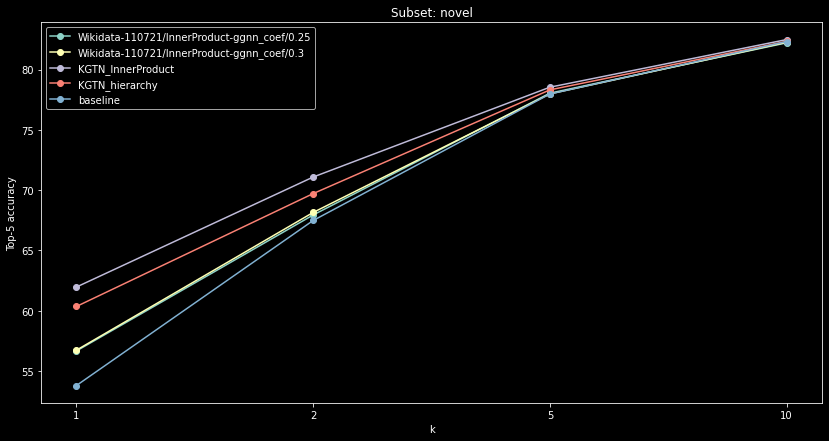

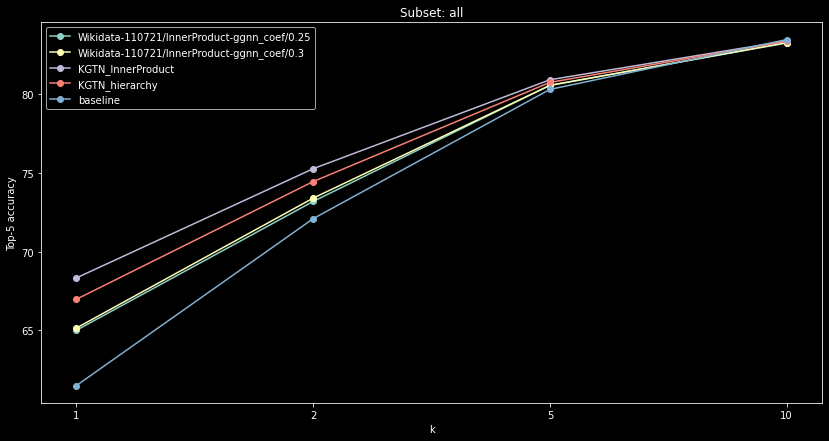

In [33]:

labels = ["1", "2", "5", "10"]

for current_type in ['novel', 'all']:
    plt.figure(figsize=(14,7))
    for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
        plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
        plt.legend()
        plt.title(f'Subset: {current_type}')
        plt.ylabel('Top-5 accuracy')
        plt.xlabel('k')

    plt.show()
